In [1]:
#EP Phys 512
#Question 3

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

In [3]:
#STEPS:

#STEP 1: determine how big of a step to take for the derivative
    #find noise matrix N
    #first guess for derivative matrix Am
    #second derivative matrix AmT N-1 Am
    
    #then use either:
    #Lemma 11.13 from https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h10/kompendiet/kap11.pdf
    #or simon's way:
    #dx = sqrt(diag(curvature^-1))*0.1
    
#STEP 2: 
    #enter parameters and derivative dx size into function
    #return point and derivatives Am at that point
    
#STEP 3:
    #calculate new step size and chi2
    #calculate new derivative dx size from matrix Am

#STEP 4:
    #iterate steps 2 and 3 until stopping criterea met
    #ie step size < param*10**(-2) or change in chi2 < 10**(-2)


In [4]:
#return the value and the derivative matrix for all the parameters, tau optional
#still need to pass in all parameters
#have default dx for first iteration
def value_and_deriv(pars0, dx, tau=True):
    
    y1 = get_spectrum(pars0)
    dpars = np.zeros((len(y1), len(pars0)))
    
    #suboptimal to run derivatives for each parameter even if tau unnecessary
    #but we're not markov-chaining it so it's ok
    for ii in range(0, len(pars0)):
        pars = np.copy(pars0)
        pars[ii] += dx[ii]       #add the derivative to a single parameter
        
#         print('running with pars ', pars)
        y2 = get_spectrum(pars)
        
        dpars[:, ii] = (y2-y1)/dx[ii]
    
    #clip to match data
    y1 = y1[2:1199+2]
    dpars = dpars[2:1199+2, :]
    
    if tau: #if we want to be setting tau as well
        return y1, dpars
    
    #otherwise cut out the tau derivative information
    dpars = np.concatenate( (dpars[:, 0:3], dpars[:, 4:6]), axis=1 )
    return y1, dpars
    

In [6]:
### FIRST RUN THROUGH: VARY ALL PARAMETERS EXCEPT TAU ###

pars0 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
dx0 = pars0 / 10**3 #first guess at derivative dx about a thousands of the values
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
tau = False

#create N matrix. make inverse
Ninv = np.diag(1/wmap[:,2]**2) #1/sig**2, diagonal matrix

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars0, dx0, tau)
print(cmb.shape)
print(Am.shape)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
if tau==False: #matrix will be smaller, need to plug a 0 in there
    dx = np.insert(dx, 3, 0) #add a zero to the third index

print('dx for derivatives will be', dx)

num_iters = 10
pars = np.copy(pars0) #deep copy.
chi2 = np.zeros(num_iters) #save the chi2 info

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    step = np.linalg.inv(lhs)@rhs
    dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    
    if tau==False: #matrix will be smaller, need to plug a value in there
        dx = np.insert(dx, 3, 0.01) #add some value to the third index
        step = np.insert(step, 3, 0) #step must be zero, don't want to move tau
        
    pars += step

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step)
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2)
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

(1199,)
(1199, 5)
dx for derivatives will be [2.43274559e-01 5.30750085e-05 5.12178772e-04 0.00000000e+00
 4.24191160e-12 1.33515469e-03]


/home/elizabeth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


done iteration  0  next step will be  [2.41289111e+00 2.47298283e-03 1.62039760e-02 0.00000000e+00
 6.90897458e-11 6.81006141e-03]
chi2 is  1588.237645861889
done iteration  1  next step will be  [ 1.87585901e+00  2.08020088e-05 -2.23277350e-03  0.00000000e+00
 -2.61024843e-11  2.92430300e-03]
chi2 is  1234.307766392786
delchi2 is  353.92987946910284
done iteration  2  next step will be  [ 4.62611699e-02 -2.42655877e-06 -8.35449555e-05  0.00000000e+00
 -6.64828305e-13  5.13184301e-05]
chi2 is  1227.937192027052
delchi2 is  6.370574365734001
done iteration  3  next step will be  [ 1.54518611e-04 -1.74432104e-07 -1.25736616e-06  0.00000000e+00
 -1.47018482e-14 -2.65730611e-06]
chi2 is  1227.9356705454006
delchi2 is  0.0015214816514799168
change in chi les than 0.01, exiting loop


Done fit with 5 parameters and tau fixed.
Final parameters:  [6.93351658e+01 2.24911838e-02 1.13886400e-01 5.00000000e-02
 2.04230773e-09 9.69783026e-01]
Final errors:  [2.40644074e+00 5.41095732e-04 5.24264784e-03 3.89551838e-11
 1.36333897e-02]


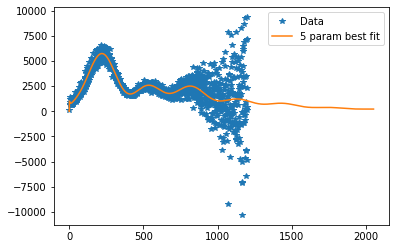

parameter  h0  value:  69.33516580820014  error:  2.4064407420603193
parameter  wbh^2  value:  0.022491183843596243  error:  0.000541095731598252
parameter  wch^2  value:  0.11388640022242832  error:  0.00524264783665426
parameter  tau  value:  0.05  error:  0.0
parameter  As  value:  2.042307731296669e-09  error:  3.895518384813578e-11
parameter  pwrlaw  value:  0.9697830255320916  error:  0.01363338967568923


In [7]:
#examining the parameter fits
final_params = np.copy(pars) #pars will be overwritten later, keep as safe copy
final_params_errs = np.sqrt(np.diag(np.linalg.inv(lhs)))
print('Done fit with 5 parameters and tau fixed.')
print('Final parameters: ', final_params)
print('Final errors: ', final_params_errs)

cmb_bestfit = get_spectrum(final_params)

mpl.figure()
mpl.plot(wmap[:,0], wmap[:,1], '*') #plot data
mpl.plot(cmb_bestfit)
mpl.legend(['Data', '5 param best fit'])
mpl.show()

np.savetxt('newton_lhs_notau_temp.txt', lhs)

par_labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
errs = np.insert(final_params_errs, 3, 0)
for ii in range(len(final_params)):
    print('parameter ', par_labels[ii], ' value: ', final_params[ii], ' error: ', errs[ii])

The errors here are somewhat ok, at least an order of magnitude below the values of the parameters. However 10 percent error is not great, and hopefully we can do better with MCMC. Note that tau doesn't actually have zero error, it just wasn't fit.

In [8]:
### STEP 2: KEEP PARAMETERS AT BEST FIT, AND VARY ONLY TAU

tau = True
tau_idx=3
pars = np.copy(final_params)
dx0 = pars / 10**3 #first guess at derivative dx about a thousandth of the values

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars, dx0, tau)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
print('pars are ', pars)
print('dx for derivatives will be', dx)


num_iters = 20
pars = np.copy(final_params)
chi2 = np.zeros(num_iters)
tau_val = np.zeros(num_iters)

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    try:
        step = np.linalg.inv(lhs)@rhs
        dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    except:
        print('lhs matrix is singular, getting out of here')
        break
        
    print('tau is ', pars[tau_idx])
    tau_val[ii] = pars[tau_idx]
    
    pars[tau_idx] += step[tau_idx] #we actually only want to increment tau
    

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step[3])
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2, '\n')
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

    lhs_old = lhs

pars are  [6.93351658e+01 2.24911838e-02 1.13886400e-01 5.00000000e-02
 2.04230773e-09 9.69783026e-01]
dx for derivatives will be [3.67152344e-01 8.52424920e-05 7.04619022e-04 1.49322046e-02
 5.93284930e-11 2.62201985e-03]
tau is  0.05
done iteration  0  next step will be  -0.005704467070724495
chi2 is  1227.9356745064342
tau is  0.04429553292927551
done iteration  1  next step will be  -0.00602865298882449
chi2 is  1237.717484645321
delchi2 is  -9.78181013888684 

tau is  0.03826687994045102
done iteration  2  next step will be  -0.009110648605471283
chi2 is  1269.862408043946
delchi2 is  -32.144923398625 

tau is  0.029156231334979736
done iteration  3  next step will be  -0.01628193213269924
chi2 is  1362.8485141419667
delchi2 is  -92.98610609802063 

tau is  0.012874299202280497
done iteration  4  next step will be  -0.025438118380208152
chi2 is  1670.9269775482715
delchi2 is  -308.07846340630476 

tau is  -0.012563819177927656
done iteration  5  next step will be  0.05889658846061

last lhs matrix was singular, using info from iteration before that
Done fit with only tau varying.
Final parameters:  [6.93351658e+01 2.24911838e-02 1.13886400e-01 2.46103420e-03
 2.04230773e-09 9.69783026e-01]
Final errors:  [2.48800191e+00 5.82283833e-04 5.10919141e-03 1.66296918e-01
 6.64283357e-10 1.53662585e-02]


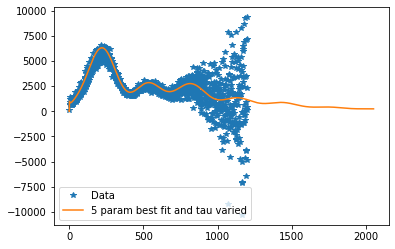

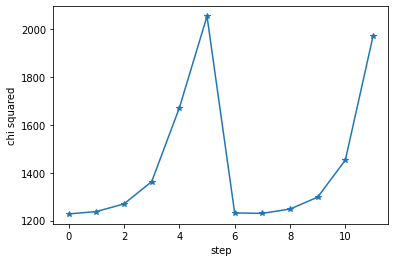

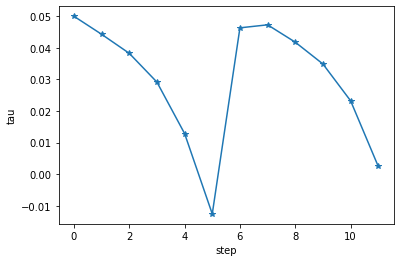

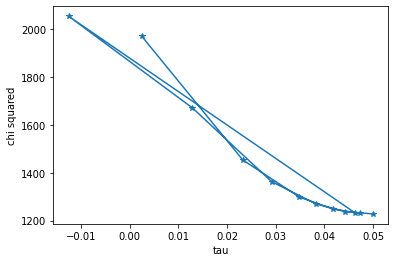

The only parameter being changed here was tau, which has huge errors larger than its own value
the final value before it settled or more likely crashed the matrix inverse was 
tau:  0.0024610341984538306  with error:  0.1662969180731327


In [9]:
#examining the parameter fits
try:
    final_params_errs_tau = np.sqrt(np.diag(np.linalg.inv(lhs)))
    final_params_tau = np.copy(pars) #pars will be overwritten later, keep as safe copy
except:
    print('last lhs matrix was singular, using info from iteration before that')
    lhs = lhs_old
    final_params_errs_tau = np.sqrt(np.diag(np.linalg.inv(lhs)))
    pars[tau_idx] -= step[tau_idx] #undo the last unstable step
    final_params_tau = np.copy(pars) #pars will be overwritten later, keep as safe copy

    
    
print('Done fit with only tau varying.')
print('Final parameters: ', final_params_tau)
print('Final errors: ', final_params_errs_tau)

cmb_bestfit_tau = get_spectrum(final_params_tau)

mpl.figure()
mpl.plot(wmap[:,0], wmap[:,1], '*') #plot data
mpl.plot(cmb_bestfit_tau)
mpl.legend(['Data', '5 param best fit and tau varied'])
mpl.show()

mpl.figure()
mpl.plot(chi2[:ii], '*-')
mpl.ylabel('chi squared')
mpl.xlabel('step')
mpl.show()

mpl.figure()
mpl.plot(tau_val[:ii], '*-')
mpl.ylabel('tau')
mpl.xlabel('step')
mpl.show()

mpl.figure()
mpl.plot(tau_val[:ii], chi2[:ii], '*-')
mpl.ylabel('chi squared')
mpl.xlabel('tau')
mpl.show()

np.savetxt('newton_lhs_onlytau_temp.txt', lhs)

print('The only parameter being changed here was tau, which has huge errors larger than its own value')
print('the final value before it settled or more likely crashed the matrix inverse was ')
print('tau: ', final_params_tau[3], ' with error: ', final_params_errs_tau[3])

I would have expected varying tau to decrease the errors, as adding in another parameter to the model should allow the model to fit better. This is not the case, however. It seems as though tau thinks it finds some other minimum somewhere in the unphysical negatives and goes running off towards it, even though it increases chi squared. At points it regains its senses for a moment and then goes back to around 0.05, but slides back away towards the negatives soon after, causing problems and singular matrices. Note that its error is larger than its value! This kind of instability is hard to fit with Newton's method, MCMC should fit it better.

In [10]:
#RUN AGAIN TO GET GOOD CURVATURE MATRIX: run with best parameters and tau=0.05
#produce ENTIRE curvature matrix to use for cholesky's method for problem 4

#use previous final parameters, which were 'pars'
pars = np.copy(final_params)
dx0 = pars / 10**3 #first guess at derivative dx about a thousands of the values
tau = True

#first iteration, guess at dx0 and refine it
cmb, Am = value_and_deriv(pars0, dx0, tau)

#using about a tenth of the error in curvature to say how big derivative steps should be
dx = 0.1*np.sqrt(np.diag( np.linalg.inv((Am.T@Ninv@Am)) ))
if tau==False: #matrix will be smaller, need to plug a 0 in there
    dx = np.insert(dx, 3, 0) #add a zero to the third index

print('dx for derivatives will be', dx)

num_iters = 1 #ONLY RUN THROUGH ONCE. want FIRST lhs matrix.
chi2 = np.zeros(num_iters)

#iterate though.
for ii in range(num_iters):
    y, Am = value_and_deriv(pars, dx, tau)
    resid = wmap[:,1] - y
    rhs = Am.T@(Ninv@resid)
    lhs = Am.T@Ninv@Am
    
    step = np.linalg.inv(lhs)@rhs
    dx = 0.1*np.sqrt(np.diag( np.linalg.inv((lhs)) )) #grab a new derivative step size
    
    if tau==False: #matrix will be smaller, need to plug a value in there
        dx = np.insert(dx, 3, 0.01) #add some value to the third index
        step = np.insert(step, 3, 0) #step must be zero, don't want to move tau
        
    pars += step

    chi2[ii] = resid.T@Ninv@resid
    print('done iteration ', ii, ' next step will be ', step)
    print('chi2 is ', chi2[ii])
    
    #check difference in chi2
    if ii > 0:
        delchi2 = chi2[ii-1]-chi2[ii]
        print('delchi2 is ', delchi2)
        if np.abs(delchi2) < 0.01:
            print('change in chi les than 0.01, exiting loop')
            break

dx for derivatives will be [3.56271206e-01 7.80703465e-05 6.66405897e-04 1.45526301e-02
 5.66984762e-11 2.48645724e-03]
done iteration  0  next step will be  [-1.24723239e-01 -2.92891578e-05  2.11107322e-04 -5.90011910e-03
 -2.29546832e-11 -9.98163828e-04]
chi2 is  1227.9356745064342


In [11]:
#save the lhs matrix for use in problem 4
print(lhs)

#will be overwritten each time
np.savetxt('newton_lhs.txt', lhs)

# test = np.loadtxt('newton_lhs.txt')
# print(lhs - test)

[[ 2.28705440e+00 -3.63357567e+03  1.21766508e+03  2.10081210e+02
  -5.17480706e+10  2.88360048e+01]
 [-3.63357567e+03  1.78671795e+07 -1.95496174e+06 -2.23827467e+05
   5.63009769e+13 -4.55138632e+05]
 [ 1.21766508e+03 -1.95496174e+06  1.78276276e+06  6.52030015e+05
  -1.62700934e+14  1.70232652e+05]
 [ 2.10081210e+02 -2.23827467e+05  6.52030015e+05  2.88208465e+05
  -7.20084829e+13  7.07826253e+04]
 [-5.17480706e+10  5.63009769e+13 -1.62700934e+14 -7.20084829e+13
   1.80033918e+22 -1.79686572e+13]
 [ 2.88360048e+01 -4.55138632e+05  1.70232652e+05  7.07826253e+04
  -1.79686572e+13  4.05807522e+04]]


In [12]:
#SANE DERIVATIVES PLOT

#EACH PARAMETER ON ITS OWN
    #TAKE STEPS SMALLER THAN STEP SIZE maybe +-d , +-2d, nothing too crazy
    #use CHI2 to see that it should be going down in a SANE manner
#should be GOING DOWN LINEARLY.
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
pars0 = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
dx0 = np.asarray([3.56271206e-01, 7.80703465e-05, 6.66405897e-04, 1.45526301e-02,
 5.66984762e-11, 2.48645724e-03]) #from one of the newton steps
dx0 = dx0 / 10**(2)
par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']


num=5
chi = np.zeros((len(pars0), num))

for jj in range(len(pars0)): #run through all the parameters
    pars = np.copy(pars0)
    for ii in range(num):
        pars[jj] = pars0[jj] + dx0[jj]*(ii-2) #run from -2 to 2 adding in dx
#         print('pars are ', pars)
        cmb = get_spectrum(pars)[2:1199+2]
        chi[jj, ii] = np.sum( (wmap[:,1]-cmb)**2/(wmap[:,2]**2) )

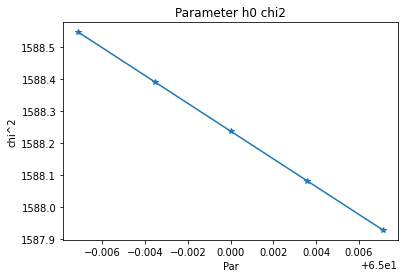

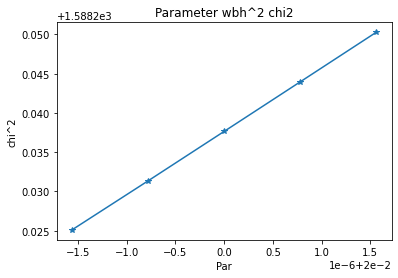

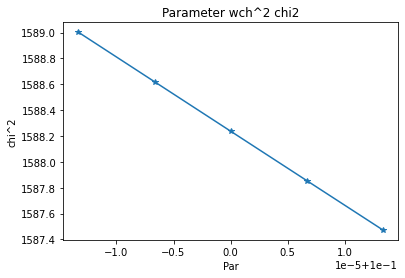

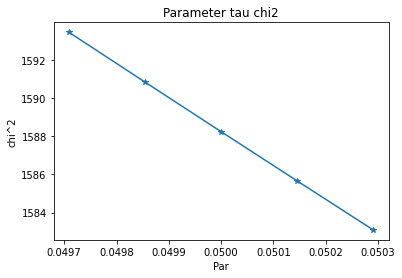

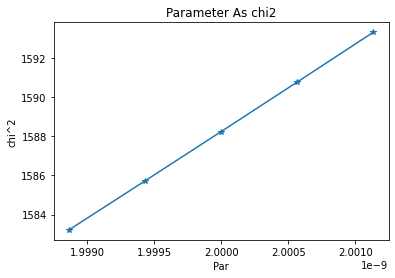

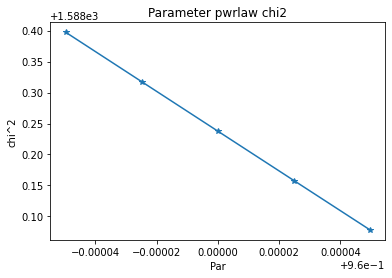

In [13]:
#plot the chi^2
for jj in range(len(pars0)): #run through all the parameters
    mpl.figure()
    mpl.plot(pars0[jj]+dx0[jj]*np.arange(-2, 3), chi[jj, :], '*-')
    mpl.title('Parameter ' + par_lab[jj] + ' chi2')
    mpl.xlabel('Par')
    mpl.ylabel('chi^2')
    mpl.show()

chi^2 changing linearly at the points expanded around the main point.
If chi^2 is behaving in a sane, linear fashion, then our derivatives, which are linear approximations, will be too.